In [129]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        brightness_range=[0.3,1.0],
        validation_split=0.1
)

batch_size = 64
shape = (224, 224)

base_dir = "/home/otiose/repos/epita/majurca/"

data_dir = base_dir + "data"

train_generator = train_datagen.flow_from_directory(
        directory=data_dir,
        target_size=shape,
        batch_size=batch_size,
        subset="training",
        class_mode="categorical")

validation_generator = train_datagen.flow_from_directory(
        directory=data_dir,
        target_size=shape,
        batch_size=batch_size,
        subset="validation",
        class_mode="categorical",
        shuffle=False
    )

Found 636 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


In [2]:
from sklearn.utils import class_weight
import numpy as np

class_weights_arr = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes), 
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights_arr))

In [3]:
inputShape = (shape+(3,))
outputShape = 7

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Flatten, 
    Dense,
    GlobalAveragePooling2D, 
    Dropout
)
from tensorflow.keras.models import Model, Sequential

base_model = VGG16(weights="imagenet", include_top=False)

#x = base_model.output
#x = Flatten()(x)
#output = Dense(outputShape, activation='softmax')(x)


x = base_model.get_layer('block5_conv3').output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(outputShape, activation='sigmoid')(x)

model = Model(inputs=base_model.inputs, outputs=x)

In [5]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import clone_model

for layer in base_model.layers:
    layer.trainable = False

#optimizer = SGD(lr=0.2, momentum=0.9, decay=0.01)
optimizer = Adam()

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    class_weight=class_weights,
    epochs=10
)

Epoch 1/10
10/10 [==============================] - 31s 3s/step - loss: 2.0071 - accuracy: 0.1384 - val_loss: 1.9403 - val_accuracy: 0.1429
Epoch 2/10
10/10 [==============================] - 10s 1s/step - loss: 1.9640 - accuracy: 0.1352 - val_loss: 1.9293 - val_accuracy: 0.2000
Epoch 3/10
10/10 [==============================] - 10s 1s/step - loss: 1.9431 - accuracy: 0.1651 - val_loss: 1.9246 - val_accuracy: 0.2857
Epoch 4/10
10/10 [==============================] - 10s 1s/step - loss: 1.9313 - accuracy: 0.1824 - val_loss: 1.9154 - val_accuracy: 0.2429
Epoch 5/10
10/10 [==============================] - 11s 1s/step - loss: 1.9309 - accuracy: 0.1918 - val_loss: 1.9122 - val_accuracy: 0.3000
Epoch 6/10
10/10 [==============================] - 10s 1s/step - loss: 1.9103 - accuracy: 0.2075 - val_loss: 1.8865 - val_accuracy: 0.2571
Epoch 7/10
10/10 [==============================] - 10s 992ms/step - loss: 1.8984 - accuracy: 0.2201 - val_loss: 1.8694 - val_accuracy: 0.3714
Epoch 8/10
10/10 

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = Adam(lr=1e-5)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [95]:
from tensorflow.keras.models import load_model

model = load_model(base_dir + "model/model-02/model.h5")

In [53]:
history = model.fit(
    x=train_generator,
    validation_data=validation_generator,
    class_weight=class_weights,
    epochs=300
)

Epoch 1/10
10/10 [==============================] - 11s 1s/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.4688 - val_accuracy: 0.9143
Epoch 2/10
10/10 [==============================] - 10s 1s/step - loss: 0.0376 - accuracy: 0.9906 - val_loss: 0.6147 - val_accuracy: 0.8571
Epoch 3/10
10/10 [==============================] - 10s 1s/step - loss: 0.0270 - accuracy: 0.9953 - val_loss: 0.4834 - val_accuracy: 0.8857
Epoch 4/10
10/10 [==============================] - 10s 1s/step - loss: 0.0281 - accuracy: 0.9953 - val_loss: 0.5534 - val_accuracy: 0.8857
Epoch 5/10
10/10 [==============================] - 10s 1s/step - loss: 0.0243 - accuracy: 0.9953 - val_loss: 0.5672 - val_accuracy: 0.8857
Epoch 6/10
10/10 [==============================] - 10s 1s/step - loss: 0.0507 - accuracy: 0.9890 - val_loss: 0.6994 - val_accuracy: 0.8286
Epoch 7/10
10/10 [==============================] - 10s 1s/step - loss: 0.0325 - accuracy: 0.9969 - val_loss: 0.6197 - val_accuracy: 0.8857
Epoch 8/10
10/10 [==

In [10]:
import os
import pandas as pd
from tensorflow.keras.models import save_model

model_dir = base_dir + "model/"

dirlist = os.listdir(model_dir)
if len(dirlist) == 0:
    iteration = "01"
else:
    last_iteration = int(dirlist[-1].split("-")[1])
    iteration = "{:02d}".format(last_iteration + 1)

save_dir = model_dir + "model-" + iteration + "/"
os.mkdir(save_dir)

save_model(model, save_dir + "model.h5", save_format="h5")
hist_df = pd.DataFrame(history.history) 
hist_csv_file = save_dir + "history.csv"

with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [132]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_prob = model.predict(validation_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = validation_generator.classes

In [134]:
target_names = [os.path.basename(path) for path in glob(data_dir + "/*")]

print(classification_report(y_true, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

       pe-hd-opaque       1.00      1.00      1.00        10
         pet-colore       0.73      0.80      0.76        10
pet-barquette-clair       0.73      0.80      0.76        10
         pet-opaque       1.00      1.00      1.00        10
                 pp       0.90      0.90      0.90        10
          pet-fonce       0.82      0.90      0.86        10
          pet-clair       1.00      0.70      0.82        10

           accuracy                           0.87        70
          macro avg       0.88      0.87      0.87        70
       weighted avg       0.88      0.87      0.87        70



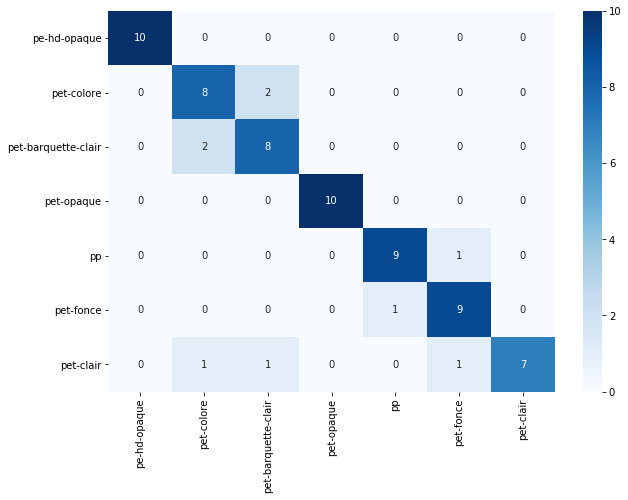

In [135]:
import seaborn as sn
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, index = labels, columns = labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap=plt.cm.Blues)
plt.show()